In [1]:
# First we grab the model and the unembedding weight matrix
import torch
from easy_transformer import EasyTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

unembed = model.unembed.W_U.data
unembed_bias = model.unembed.b_U.data
d_model = model.cfg.d_model
d_vocab = model.cfg.d_vocab

/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [2]:
    
# Convenience function for decoding token
decode = model.tokenizer.decode

def decode_pad(t):
    string = decode(t)
    return f'{string:10}'

# Turn the embedding vector into a set of token probabilities
def embed_vector_to_probs(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    return torch.nn.functional.softmax(logits, dim=0)

# A function for understanding a vector in embedding space
def print_embed_vector(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    probs = torch.nn.functional.softmax(logits, dim=0)
    values = [(v.item(),i) for i,v in enumerate(logits)]
    values.sort(reverse=True)
    for i in range(10):
        j = values[i][1]
        print(f'{decode_pad(j)} {values[i][0]} {probs[j]}')
    print('  ...')
    for i in range(d_vocab-5,d_vocab):
        j = values[i][1]
        print(f'{decode_pad(j)} {values[i][0]} {probs[j]}')


In [8]:
# Choose some tokens ("common" according to the bias vector, but not too common because those are mostly boring stop words)
from nltk.corpus import wordnet as wn
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

num_wanted = 100
seen = set()
chosen_tokens = []
for synset in wn.all_synsets('n'):
    tok = ' ' + synset.name().split('.')[0]
    enc = model.tokenizer.encode(tok)
    if len(enc) == 1 and tok not in seen:
        chosen_tokens.append(enc[0])

import random
random.seed(12345)
chosen_tokens = random.sample(chosen_tokens, k=num_wanted)
        
#values = [(v.item(), i) for i,v in enumerate(unembed_bias)]
#values.sort(reverse=True)
#chosen_tokens = [i for v,i in values[500:600]]
print(list(decode(t) for t in chosen_tokens))

[nltk_data] Downloading package omw-1.4 to /home/giles/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/giles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[' channel', ' gray', ' assumption', ' square', ' tongue', ' thousand', ' animation', ' health', ' system', ' cross', ' skirt', ' rye', ' timetable', ' balance', ' process', ' shot', ' cement', ' prayer', ' router', ' mint', ' tendency', ' bullet', ' center', ' breast', ' coil', ' insulin', ' spark', ' grey', ' sob', ' fall', ' marks', ' defensive', ' chorus', ' specification', ' billboard', ' beetle', ' filling', ' stranger', ' center', ' cooler', ' polarization', ' viability', ' black', ' road', ' statement', ' depth', ' reaction', ' passing', ' junior', ' focus', ' communication', ' interchange', ' maneuver', ' boy', ' cement', ' base', ' rate', ' pedigree', ' cape', ' toy', ' exploration', ' eve', ' extremism', ' replay', ' wax', ' feminist', ' firm', ' center', ' peel', ' taste', ' lounge', ' consolidation', ' council', ' rabbi', ' fork', ' overlap', ' drop', ' pilgrimage', ' loft', ' name', ' seal', ' declaration', ' handle', ' reiter', ' fifteen', ' violet', ' rack', ' closer', 

In [9]:
# Attempt to calculate the "auspicious vectors" using the Moore-Penrose pseudoinverse
ausp1 = torch.nn.functional.normalize(torch.linalg.pinv(unembed.to('cpu')), dim=1)
for t in chosen_tokens[:5]:
    print(decode(t))
    print_embed_vector(ausp1[t,:])
    print()


 channel
 channel   3.382958173751831 0.0005802617524750531
 channels  2.459916591644287 0.00023054308257997036
channel    2.0281009674072266 0.00014969833137001842
 Channel   1.9270963668823242 0.00013531662989407778
Channel    1.7485089302062988 0.00011318572796881199
annels     1.4258332252502441 8.1970079918392e-05
 network   0.8108593821525574 4.431753768585622e-05
 outlet    0.8021986484527588 4.3935371650150046e-05
annel      0.7891892194747925 4.336749771027826e-05
 stream    0.781872570514679 4.305135371396318e-05
  ...
alter      -0.49632731080055237 1.1991448445769493e-05
zens       -0.5008589029312134 1.1937230738112703e-05
ossibility -0.5135537385940552 1.1786646609834861e-05
anto       -0.5685431957244873 1.1156005712109618e-05
etsk       -0.6036497950553894 1.0771149391075596e-05

 gray
 gray      3.1477928161621094 0.00045878917444497347
 grey      2.493051767349243 0.00023837611661292613
gray       1.9681178331375122 0.00014102198474574834
Gray       1.5938279628753662

Next, we want to see if these auspicious vectors can be added to get the result we expect. The expected result is that (a + b) gives a probability vector of 50% a, 50% b.

<AxesSubplot:>

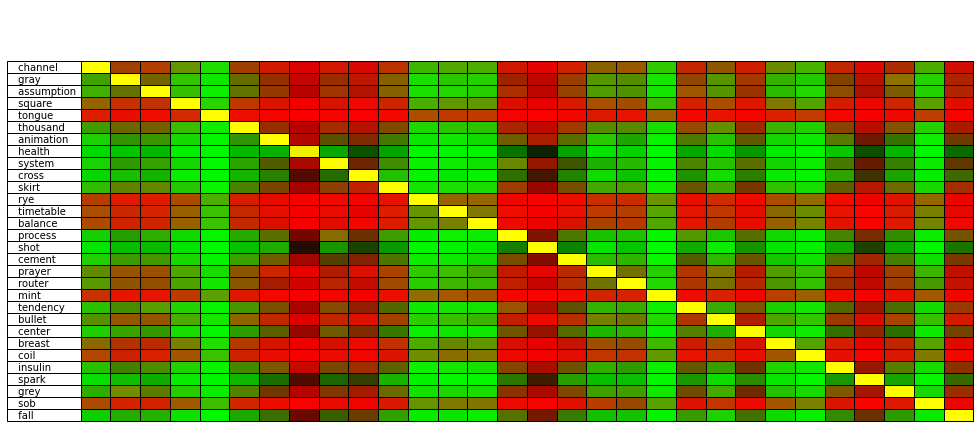

In [39]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 1]
plt.rcParams["figure.autolayout"] = True

num = 30
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        #v1 = 30 * chosen_ausp[i,:]
        #v2 = 30 * chosen_ausp[j,:]
        v1 = 4 * ausp1[chosen_tokens[i],:]
        v2 = 4 * ausp1[chosen_tokens[j],:]
        combo = v1 + v2
        probs = embed_vector_to_probs(combo)
        r = probs[chosen_tokens[i]].item()
        g = probs[chosen_tokens[j]].item()
        b = 0
        colors[-1].append((r,g,b))
        
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax

<AxesSubplot:>

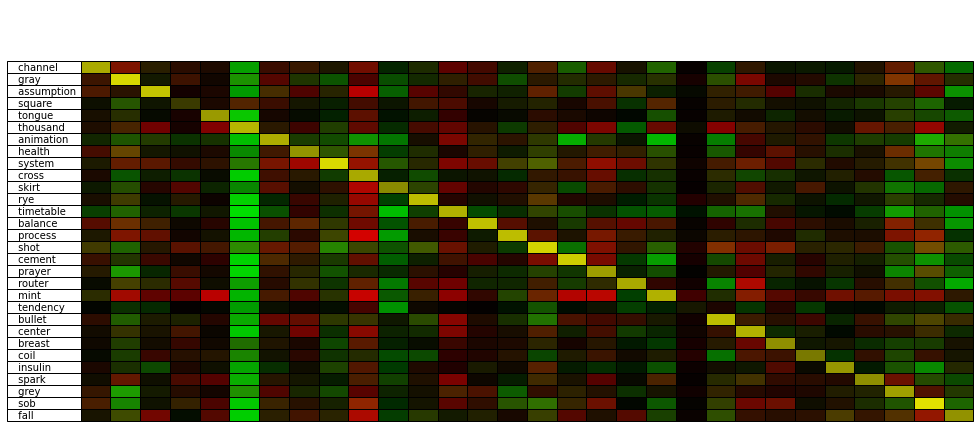

In [42]:
num = 30
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        index0 = chosen_tokens[i]
        index1 = chosen_tokens[j]
        #prompt = f"If I had to choose between the{decode(index0)} and the{decode(index1)}, I would choose the"
        prompt = f"{decode(index0)}{decode(index1)}{decode(index1)}{decode(index0)}{decode(index1)}"
        logits = model(prompt)[0, -1, :]
        probs = torch.softmax(logits, dim=0)
        r = probs[index0].item()
        g = probs[index1].item()
        colors[-1].append((r,g,b))
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax

<AxesSubplot:>

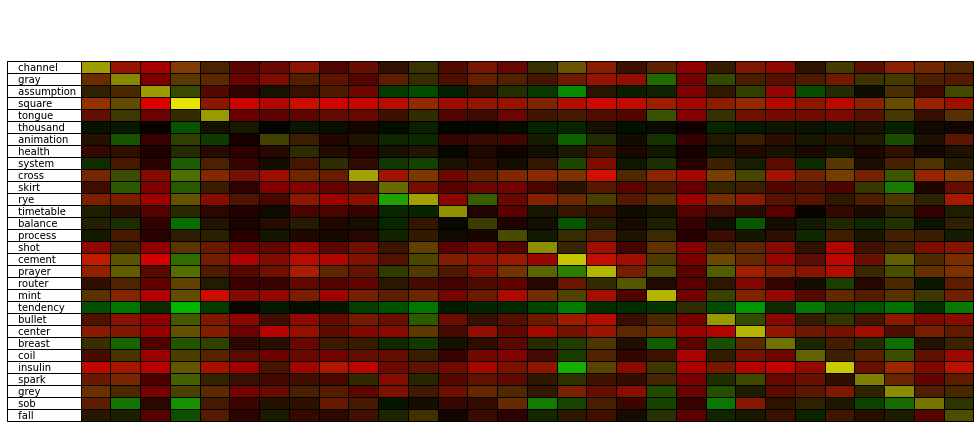

In [43]:
num = 30
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        index0 = chosen_tokens[i]
        index1 = chosen_tokens[j]
        prompt = f"If I had to choose between the{decode(index0)} and the{decode(index1)}, I would choose the"
        logits = model(prompt)[0, -1, :]
        probs = torch.softmax(logits, dim=0)
        r = probs[index0].item()
        g = probs[index1].item()
        colors[-1].append((r,g,b))
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax